In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from typing import List

# plt.style.use("bmh")
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.grid'] = True

In [2]:
def cargar_datos(file_name : str) -> list:
    # Cargamos los datos
    with open(file_name, "rb") as f:
        dic = pickle.load(f)
    # Hago una lista con los valores de frecuencia que alimentamos con el generador de funciones
    freq_values_keys = list(dic.keys())
    # Le sacamos la "Hz" a las keys
    freq_values = [float(freq[:-2]) for freq in freq_values_keys]
    t1, V1 = [dic[f'{freq}Hz']['t_1']/1000 for freq in freq_values], [dic[f'{freq}Hz']['V_1'] for freq in freq_values]
    t2, V2 = [dic[f'{freq}Hz']['t_2']/1000 for freq in freq_values], [dic[f'{freq}Hz']['V_2'] for freq in freq_values]
    amp1 = np.array([np.max(v1)-np.min(v1) for v1 in V1]) # para ver los datos sobre la hora, hay que calcular bien esto
    amp2 = np.array([np.max(v2)-np.min(v2) for v2 in V2]) # para ver los datos sobre la hora, hay que calcular bien esto

    scale_1 = [dic[freq]["scale"][0] for freq in freq_values_keys]

    scale_2 = [dic[freq]["scale"][1] for freq in freq_values_keys]

    amp1_err = np.array([np.sqrt((0.004*max(v1)+ 3/1000 + 0.1*scale_1[i])**2+(0.004*min(v1)+ 3/1000 + 0.1*scale_1[i])**2) for i,v1 in enumerate(V1)])
    # print(max(V2[-1]),0.004*max(V2[-1])+ 3/1000 + 0.1*scale_2[0])
    # print(amp1[-1], amp1_err[-1])
    # print("\n")

    # print((0.004*max(V2[-1])+ 3/1000 + 0.1*scale_2[0])/max(V1[-1]))
    amp2_err = np.array([np.sqrt((0.004*max(v2)+ 3/1000 + 0.1*scale_2[i])**2+(0.004*min(v2)+ 3/1000 + 0.1*scale_2[i])**2) for i,v2 in enumerate(V2)])
    # print(amp2[-1], amp2_err[-1])
    # Creamos una lista para guardar todos los datos que nos interesan
    
    amp1_err = np.array([np.sqrt((0.02*min(v1))**2+(0.02*max(v1))**2) for v1 in V1])
    amp2_err = np.array([np.sqrt((0.02*min(v2))**2+(0.02*max(v2))**2) for v2 in V2])
    
    lista_mediciones = [freq_values, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err]

    return lista_mediciones

In [3]:
file_name = ("../mediciones/D.D/Tiempo de respuesta del laser/Barrido sinusoidal 02-06.pickle")
with open(file_name, "rb") as f:
        dic = pickle.load(f)

t_1 = dic["385.6620421163472Hz"]["t_1"]
V_1 = dic["385.6620421163472Hz"]["V_1"]
scale = dic["385.6620421163472Hz"]["scale"][0]
dic["385.6620421163472Hz"]["params"]

{'amp': 0.5, 'offset': 2, 'freq': 385.6620421163472}

In [11]:
a = "../mediciones/D.D/Fuente de corriente/Protoboard/Barrido sinusoidal 02-06.pickle"
dic_a = pickle.load(open("../mediciones/D.D/Fuente de corriente/Protoboard/Barrido sinusoidal 02-06.pickle", "rb"))

In [20]:
list(dic_a.values())[0]

{'t_1': array([-5000., -4990., -4980., -4970., -4960., -4950., -4940., -4930.,
        -4920., -4910., -4900., -4890., -4880., -4870., -4860., -4850.,
        -4840., -4830., -4820., -4810., -4800., -4790., -4780., -4770.,
        -4760., -4750., -4740., -4730., -4720., -4710., -4700., -4690.,
        -4680., -4670., -4660., -4650., -4640., -4630., -4620., -4610.,
        -4600., -4590., -4580., -4570., -4560., -4550., -4540., -4530.,
        -4520., -4510., -4500., -4490., -4480., -4470., -4460., -4450.,
        -4440., -4430., -4420., -4410., -4400., -4390., -4380., -4370.,
        -4360., -4350., -4340., -4330., -4320., -4310., -4300., -4290.,
        -4280., -4270., -4260., -4250., -4240., -4230., -4220., -4210.,
        -4200., -4190., -4180., -4170., -4160., -4150., -4140., -4130.,
        -4120., -4110., -4100., -4090., -4080., -4070., -4060., -4050.,
        -4040., -4030., -4020., -4010., -4000., -3990., -3980., -3970.,
        -3960., -3950., -3940., -3930., -3920., -3910., -

In [4]:
def calc_err_osci(V: np.ndarray, scale: float) -> np.ndarray:

    if scale <= 0.1: # Menor a 100 mV
        v_min = 3/1000
    elif scale <= 1:
        v_min = 30/1000
    else:
        v_min = 300/1000

    # V_err = [0.004*abs(v)+v_min+0.1*scale for v in V]
    V_err = 0.02*np.abs(V)
    return np.array(V_err)

In [5]:
file_names = ["Fuente de corriente/Barrido sinusoidal a 0.5 V de amp y 2 V de offset.pickle",
              "Tiempo de respuesta del laser/Barrido sinusoidal a 0.5 V de amp y 2 V de offset con R=50 ohm.pickle"]
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
freqs = []
Ts = []

def sin_func(t:list, A: float, f: float,phi: float):
    return A*np.sin(2*np.pi*f*np.array(t)+phi)

def ajustar_sinusoidales(t: List[np.ndarray], V: List[np.ndarray], freq_list: List[np.ndarray], graficar = False):
    amp_list = []
    amp_err_list = []
    for i in range(len(V)):
        suggested_amp = (max(V[i])-min(V[i]))/2
    
        suggested_f = freq_list[i]
        popt, pcov = curve_fit(sin_func, t[i], V[i]-np.mean(V[i]),p0 = [suggested_amp, suggested_f, 1])#, bounds =([suggested_amp-0.001, suggested_f-10,-np.inf], [suggested_amp+0.001, suggested_f+10, np.inf]), maxfev = 5000)

        amp = popt[0]
        amp_err = np.sqrt(pcov[0,0])
        # print(f"La frec es {popt[1]} sugerida: {suggested_f}")
        # print(f"La amp es {popt[0]} amp sugerida {suggested_amp}")
        amp_list.append(amp)
        amp_err_list.append(amp_err)

        if graficar:
            plt.figure()
            plt.plot(t[i], V[i]-np.mean(V[i]),".")
            plt.plot(t[i], sin_func(t[i],*popt), "--k")
            # plt.plot(t[i], sin_func(t[i],suggested_amp, suggested_f, 0), "--k", label = "esperada")
            plt.show()

    return np.abs(np.array(amp_list)), np.array(amp_err_list)

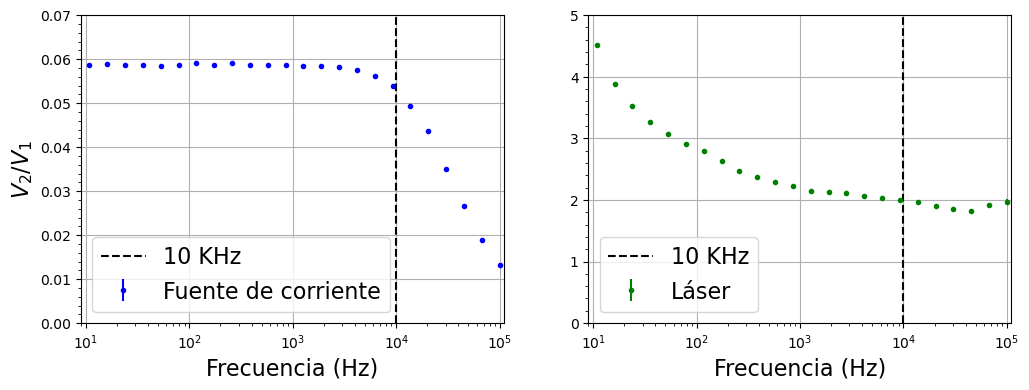

In [21]:
carpetas = ["Fuente de corriente/Protoboard", "Tiempo de respuesta del laser"] # La R del fotodiodo era de 50 Ohm para las que no se aclara
fechas = ["02-06", "12-06 2"]
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]

fig, axs = plt.subplots(nrows = 1,ncols = len(labels), figsize=(12,4))
for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal {fechas[i]}.pickle"
    f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)
    
    amp1, amp1_err = ajustar_sinusoidales(t1, V1, f, graficar = False)
    # print("cambié de medicion")
    amp2, amp2_err = ajustar_sinusoidales(t2, V2, f, graficar = False)
    T = amp2/amp1
    T_err = T*np.sqrt((amp1_err/amp1)**2+(amp2_err/amp2)**2)

    y_min_lim = 0

    ax.errorbar(f, T, yerr = T_err, label=f'{labels[i]}', color = f"{colors[i]}", fmt = ".")
    # ax.hlines(max(T)*0.7, xmin = 1, xmax =10e4, ls = "--", color = "k")
    if i == 0:
        ax.set_ylabel('$V_2/V_1$') 
        y_max_lim = 0.07

    else:
        y_max_lim = 5


    ax.set_ylim(y_min_lim,y_max_lim)      
    ax.axvline(10000, ymin = 0, ymax = 1, ls = "--", label = "10 KHz", c = "k")  
    

    ax.set_xlim(10-1, max(f)+10000)
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    #ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(loc = "lower left")
plt.show()

Separando las figuras para guardarlas en overleaf


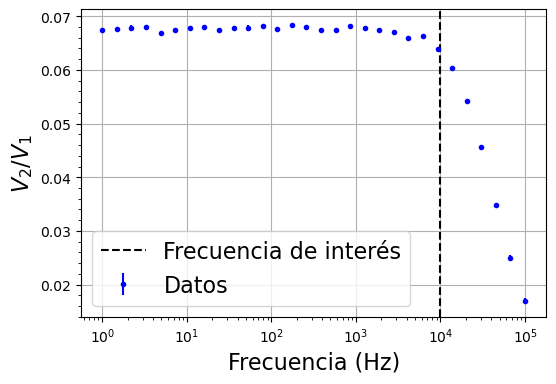

In [26]:
fig, ax = plt.subplots(nrows = 1,ncols = 1, figsize=(6,4))
file_name = f"../mediciones/D.D/Fuente de corriente/San Damian/Barrido sinusoidal.pickle"
f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)
amp1, amp1_err = ajustar_sinusoidales(t1, V1, f, graficar = False)
# print("cambié de medicion")
amp2, amp2_err = ajustar_sinusoidales(t2, V2, f, graficar = False)
T = amp2/amp1
T_err = T*np.sqrt((amp1_err/amp1)**2+(amp2_err/amp2)**2)

y_min_lim = 0

ax.errorbar(f, T, yerr = T_err, label= "Datos", color = "b", fmt = ".")
# ax.hlines(max(T)*0.7, xmin = 1, xmax =10e4, ls = "--", color = "k")
if i == 0:
    
    y_max_lim = 0.07

else:
    y_max_lim = 5


# ax.set_ylim(y_min_lim,y_max_lim)      
ax.axvline(10000, ymin = 0, ymax = 1, ls = "--", label = "Frecuencia de interés", c = "k")  

# ax.set_xlim(10-1, max(f)+10000)
ax.set_xlabel('Frecuencia (Hz)')
ax.set_ylabel('$V_2/V_1$') 
ax.set_xscale("log")
ax.legend(loc = "lower left")
labels_savefig = ["Fuente de corriente", "Láser"]
# plt.savefig(f'../imagenes/{labels_savefig[i]}/Frecuencia {labels_savefig[i]}.svg')
plt.show()

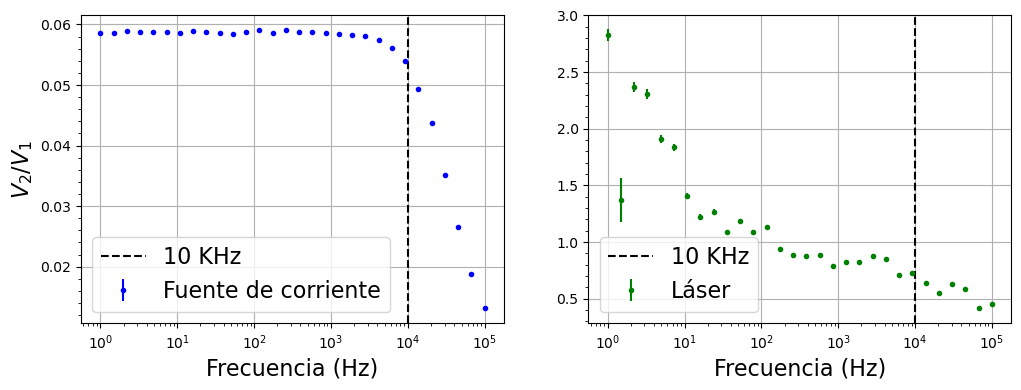

In [9]:
carpetas = ["Fuente de corriente", "Tiempo de respuesta del laser"] # La R del fotodiodo era de 50 Ohm para las que no se aclara
fechas = ["02-06", "12-06 2"]
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]

fig, axs = plt.subplots(nrows = 1,ncols = len(labels), figsize=(12,4))
for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal {fechas[i]}.pickle"
    f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)
    # print(f)
    if i == 0:
        amp1, amp1_err = ajustar_sinusoidales(t1, V1, f, graficar = False)
    # print("cambié de medicion")
    amp2, amp2_err = ajustar_sinusoidales(t2, V2, f, graficar = False)
    T = amp2/amp1
    T_err = T*np.sqrt((amp1_err/amp1)**2+(amp2_err/amp2)**2)

    y_min_lim = 0

    ax.errorbar(f, T, yerr = T_err, label=f'{labels[i]}', color = f"{colors[i]}", fmt = ".")
    # ax.hlines(max(T)*0.7, xmin = 1, xmax =10e4, ls = "--", color = "k")
    if i == 0:
        ax.set_ylabel('$V_2/V_1$') 
        y_max_lim = 0.07

    else:
        y_max_lim = 5


    #ax.set_ylim(y_min_lim,y_max_lim)      
    ax.axvline(10000, ymin = 0, ymax = 1, ls = "--", label = "10 KHz", c = "k")  
    

    #ax.set_xlim(10-1, max(f)+10000)
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    #ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend(loc = "lower left")
plt.show()

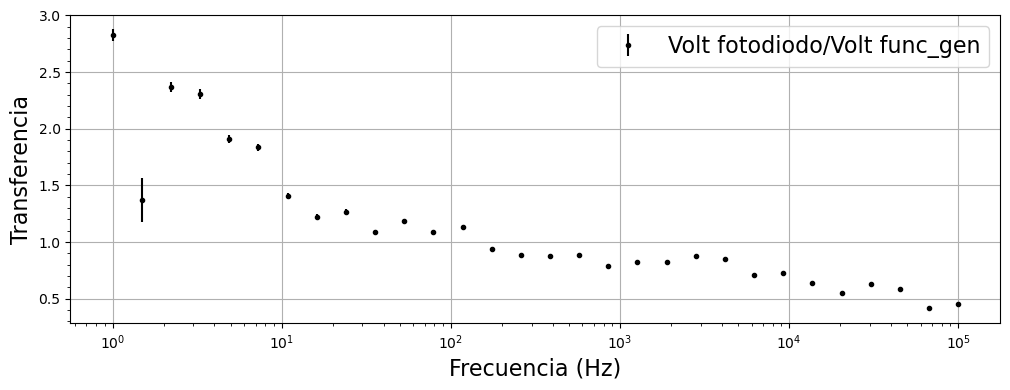

In [10]:
file_name = f"../mediciones/D.D/{carpetas[0]}/Barrido sinusoidal {fechas[0]}.pickle"
f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)
amp1, amp1_err = ajustar_sinusoidales(t1, V1, f, graficar = False)


file_name = f"../mediciones/D.D/{carpetas[1]}/Barrido sinusoidal {fechas[1]}.pickle"
f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)
amp2, amp2_err = ajustar_sinusoidales(t2, V2, f, graficar = False)
T = amp2/amp1
T_err = T*np.sqrt((amp1_err/amp1)**2+(amp2_err/amp2)**2)
fig, ax = plt.subplots(figsize=(12,4))
ax.errorbar(f, T, yerr = T_err, label=f'Volt fotodiodo/Volt func_gen', color = "k", fmt = ".")
# ax.hlines(max(T)*0.7, xmin = 1, xmax =10e4, ls = "--", color = "k")

ax.set_ylabel('Transferencia')     
ax.set_xlabel('Frecuencia (Hz)')
# ax.title(f'R={R}')
#ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()

# No se, es viejo

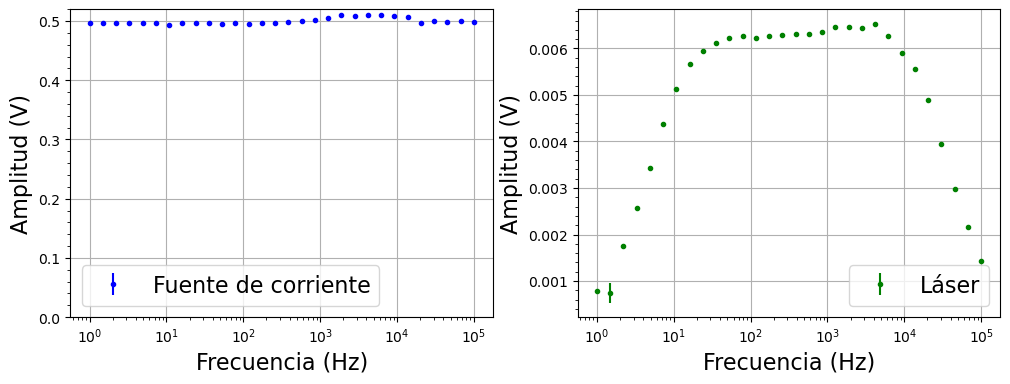

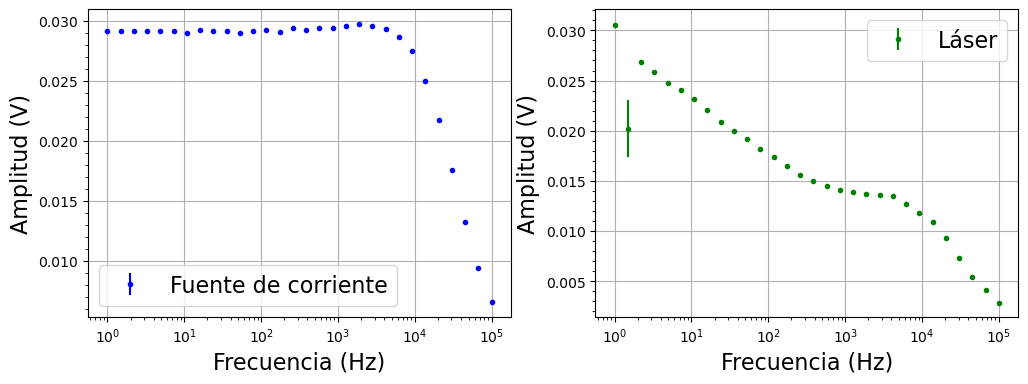

In [9]:
fig, axs = plt.subplots(1,len(labels), figsize=(12,4))
fig1, axs1 = plt.subplots(1,len(labels), figsize=(12,4))
for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal {fechas[i]}.pickle"
    f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)

    amp1, amp1_err = ajustar_sinusoidales(t1, V1, f)
    amp2, amp2_err = ajustar_sinusoidales(t2, V2, f, graficar = False)
    

    ax.errorbar(f, amp1, yerr = amp1_err, label=f'{labels[i]}', color = f"{colors[i]}", fmt = ".")
    if i ==0:
        ax.set_ylim(0,0.52)
    ax.set_ylabel('Amplitud (V)') 
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    # ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    
    axs1[i].errorbar(f, amp2, yerr = amp2_err, label=f'{labels[i]}', color = f"{colors[i]}", fmt = ".")
    
    axs1[i].set_ylabel('Amplitud (V)') 
    axs1[i].set_xlabel('Frecuencia (Hz)')
    # axs1[i].title(f'R={R}')
    # axs1[i].set_yscale("log")
    axs1[i].set_xscale("log")
    axs1[i].legend()


plt.show()

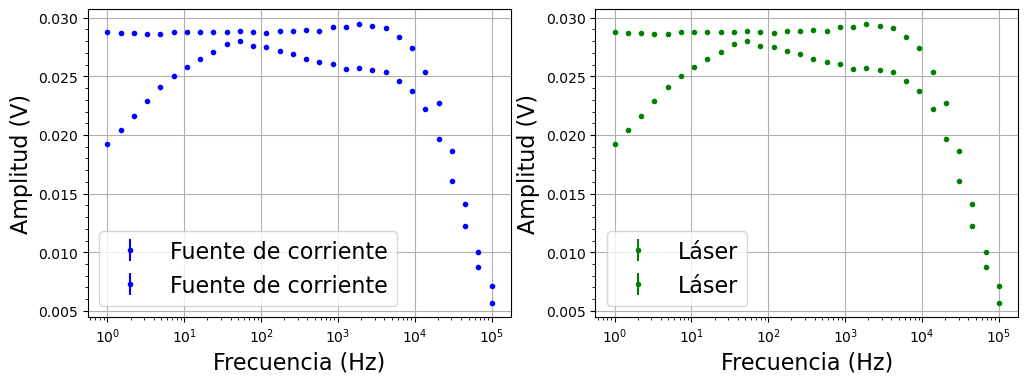

In [10]:
fig, axs = plt.subplots(1,len(labels), figsize=(12,4))

for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[1]}/Barrido sinusoidal 02-06.pickle"
    f, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err= cargar_datos(file_name)

    amp1, amp1_err = ajustar_sinusoidales(t1, V1, f)
    amp2, amp2_err = ajustar_sinusoidales(t2, V2, f, graficar = False)
    

    ax.errorbar(f, amp1, yerr = amp1_err, label=f'{labels[i]}', color = f"{colors[i]}", fmt = ".")
    ax.errorbar(f, amp2, yerr = amp2_err, label=f'{labels[i]}', color = f"{colors[i]}", fmt = ".")
  
    ax.set_ylabel('Amplitud (V)') 
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    # ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
  


plt.show()

# Método sin ajustar

[1.04 1.04 1.02 1.02 1.02 1.04 1.02 1.04 1.04 1.04 1.02 1.02 1.04 1.02
 1.04 1.04 1.04 1.04 1.04 1.06 1.06 1.06 1.06 1.06 1.04 1.08 1.08 1.06
 1.08 1.08]
[0.11465008 0.11465008 0.11489473 0.11489473 0.11489473 0.11465008
 0.11489473 0.11465008 0.11465008 0.11465008 0.11489473 0.11489473
 0.11465008 0.11489473 0.11465008 0.11465008 0.11465008 0.11465008
 0.11465008 0.11440629 0.11496713 0.11496713 0.11496713 0.11440629
 0.11465008 0.11416339 0.11416339 0.11440629 0.11472402 0.11472402]
[0.062 0.066 0.062 0.062 0.062 0.062 0.062 0.062 0.064 0.06  0.062 0.064
 0.062 0.062 0.062 0.062 0.062 0.062 0.064 0.062 0.062 0.064 0.06  0.064
 0.056 0.054 0.048 0.036 0.028 0.022]
[0.00631202 0.00626418 0.00631202 0.00631202 0.00631202 0.00631202
 0.00631202 0.00631202 0.00634401 0.00633618 0.00631202 0.00628802
 0.00631202 0.00631202 0.00631202 0.00631202 0.00631202 0.00631202
 0.00634401 0.00631202 0.00631202 0.00634401 0.00633618 0.00634401
 0.00632885 0.00635346 0.00631569 0.00629971 0.00629158 0.

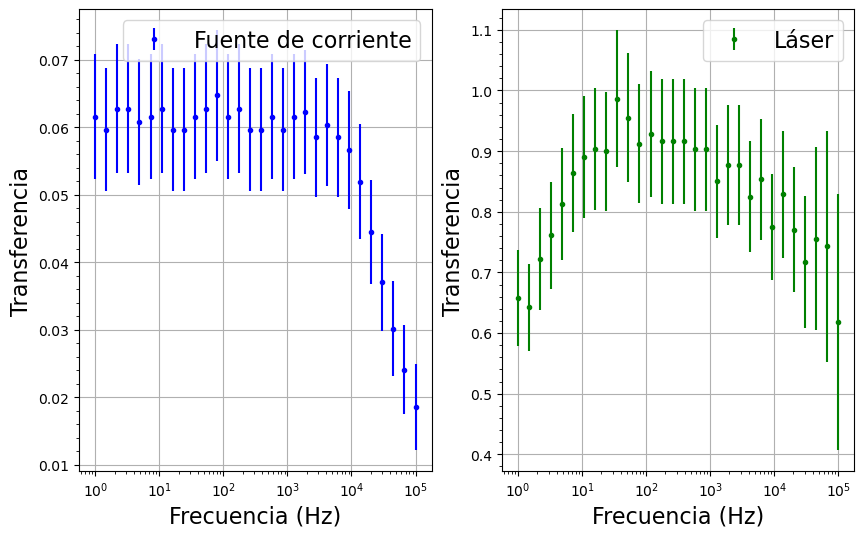

In [11]:
carpetas = ["Fuente de corriente", "Tiempo de respuesta del laser"] # La R del fotodiodo era de 50 Ohm
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
Ts = []

fig, axs = plt.subplots(ncols = 2, figsize = (10,6))

for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal 02-06.pickle"
    freqs, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err = cargar_datos(file_name)

    print(amp1)
    print(amp1_err)
    T = amp2/amp1
    # T_err = np.sqrt((amp2_err/amp1)**2+((amp2/(amp1**2))*amp1_err)**2)
    T_err = T*np.sqrt((amp1_err/amp1)**2+(amp2_err/amp2)**2)
    Ts.append(T)
    ax.errorbar(freqs, T, yerr = T_err, color = colors[i], label = labels[i], fmt = ".")
    # ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel('Transferencia') 
    ax.set_xlabel('Frecuencia (Hz)')
    # ax.title(f'R={R}')
    ax.legend()
plt.show()

0.064 0.0065120196559899915
0.0408 0.0025660428679193967


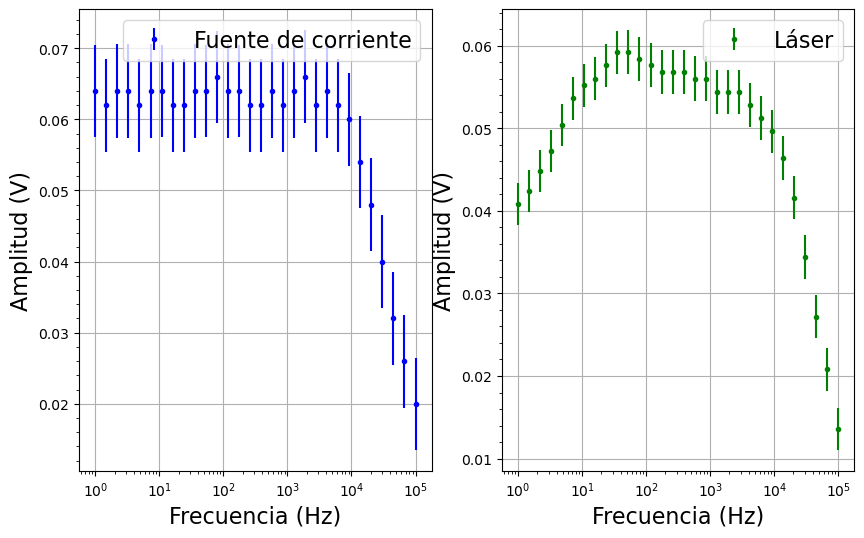

In [12]:
carpetas = ["Fuente de corriente", "Tiempo de respuesta del laser"] # La R del fotodiodo era de 50 Ohm
labels = ["Fuente de corriente", "Láser"]
colors = ["b", "g"]
Ts = []

fig, axs = plt.subplots(ncols = 2, figsize = (10,6))

for i, ax in enumerate(fig.axes):
    file_name = f"../mediciones/D.D/{carpetas[i]}/Barrido sinusoidal 02-06.pickle"
    freqs, t1, V1, t2, V2, amp1, amp2, amp1_err, amp2_err = cargar_datos(file_name)
    print(amp2[0], amp2_err[0])



    ax.errorbar(freqs, amp2, yerr = amp2_err, color = colors[i], label = labels[i], fmt = ".")
    # ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel('Amplitud (V)') 
    ax.set_xlabel('Frecuencia (Hz)')
    ax.legend()
plt.show()